In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import backend as K

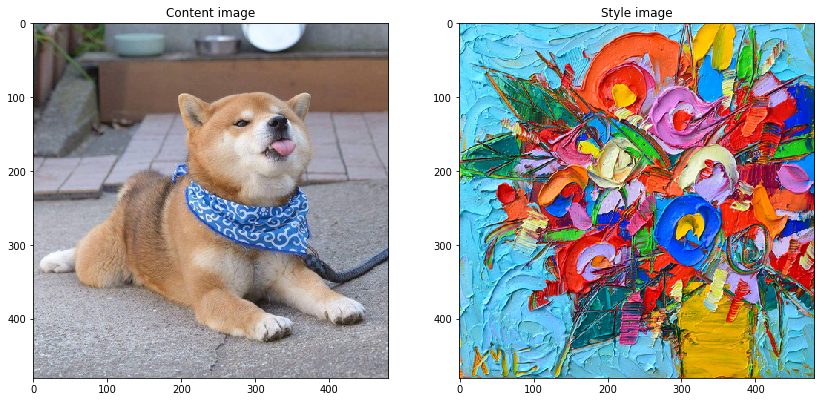

In [11]:
# Read in shiba.jpg as content image
def imread(fname, size=(480, 480)):
    im = Image.open(fname)
    im = im.crop((0, 0, min(im.size), min(im.size)))
    im.thumbnail(size, Image.ANTIALIAS)
    im = np.array(im).reshape(1, size[0], size[1], 3)
    return np.float32(im) / np.max(im)
    
content_im = imread('shiba.jpg')
style_im = imread('flowers.jpg')

plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.title('Content image')
plt.imshow(content_im[0])

plt.subplot(1, 2, 2)
plt.title('Style image')
plt.imshow(style_im[0])
plt.show()

In [4]:
# Import VGG16 with pre-trained ImageNet weights.
model = VGG16(weights='imagenet', include_top=False)
print('VGG16 Architecture:')
model.summary()

VGG16 Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0

In [5]:
def gram(x):
    features = K.batch_flatten(K.permute_dimensions(x[0], (2, 0, 1)))
    mat = K.dot(features, K.transpose(features))
    return mat / (128**2)

style_layer_name = 'block3_conv2'# TODO: optimize w.r.t. multiple layers

# calculate output of style image
style_model = Model(inputs=model.input, outputs=model.get_layer(style_layer_name).output)
style_output = gram(style_model.predict(style_im))

In [8]:
# A loss function that measures the style loss at multiple levels
style_layer_output = model.get_layer(style_layer_name).output
style_loss = K.mean(K.square(gram(style_layer_output) - style_output))

# Computes the gradients w.r.t. the input image of both losses and combines to single gradient.
layer_grads = K.gradients(style_loss, model.input)[0]

# Create a function that returns the to-be maximized activation and gradients
update = K.function([model.input], [style_loss, layer_grads])

# start with image of Shiba
init = np.copy(content_im)

# Run gradient ascent to enhance image features
lr = 0.9
for i in range(100):
    loss, gradient = update([init])
    init -= lr * gradient
    
    if (i+1) % 10 == 0:
        print('iter', i+1, 'Current loss at layer:\t', loss)

iter 1 Current loss at layer:	 822.0917
iter 2 Current loss at layer:	 496.2897
iter 3 Current loss at layer:	 197.15405
iter 4 Current loss at layer:	 124.33847
iter 5 Current loss at layer:	 113.970535
iter 6 Current loss at layer:	 94.31577
iter 7 Current loss at layer:	 106.20017
iter 8 Current loss at layer:	 67.37486
iter 9 Current loss at layer:	 66.33334
iter 10 Current loss at layer:	 51.73665
iter 11 Current loss at layer:	 42.596535
iter 12 Current loss at layer:	 35.207817
iter 13 Current loss at layer:	 30.011938
iter 14 Current loss at layer:	 27.121712
iter 15 Current loss at layer:	 24.949722
iter 16 Current loss at layer:	 23.33263
iter 17 Current loss at layer:	 21.920162
iter 18 Current loss at layer:	 20.742134
iter 19 Current loss at layer:	 19.667444
iter 20 Current loss at layer:	 18.737633
iter 21 Current loss at layer:	 17.878277
iter 22 Current loss at layer:	 17.11737
iter 23 Current loss at layer:	 16.41069
iter 24 Current loss at layer:	 15.7764845
iter 25 

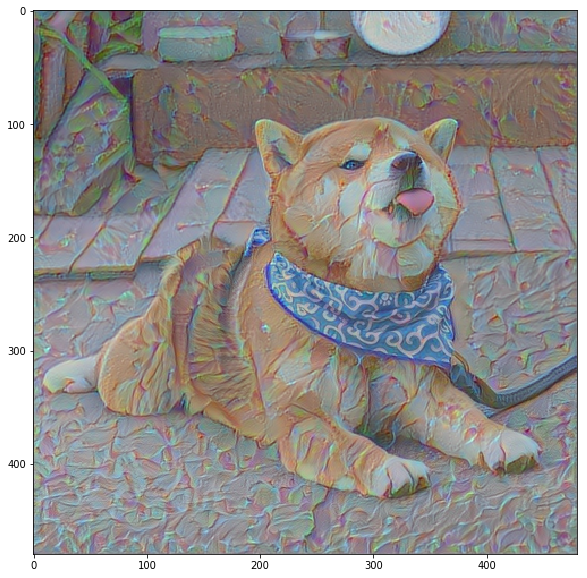

In [10]:
# normalize output to make sure that the image does not clip
init = init - np.min(init)
init = init / np.max(init)

# display image on screen
plt.figure(figsize=(10, 10))
plt.imshow(init[0], cmap='gray')
plt.show()